In [1]:
from data import*
from regression import*

Using TensorFlow backend.


In [54]:
dataset = load_dataset('synth_2coils_parallel')

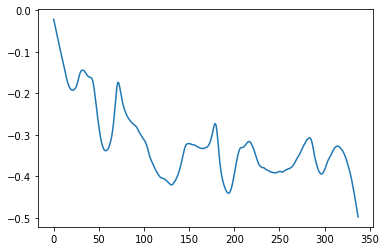

In [59]:
data = dataset[200]

n = np.array(data.norm.to_list())    
c1 = np.array(data.center_1.to_list())
c2 = np.array(data.center_2.to_list())

plt.plot(c1[:,2])

plt.show()


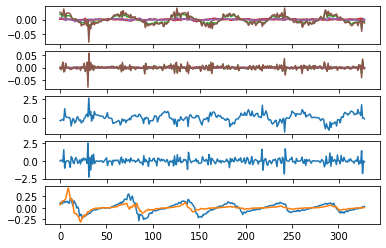

In [12]:
n = np.array(data.norm.to_list())    
c1 = np.array(data.center_1.to_list())
c2 = np.array(data.center_2.to_list())

v1 = data.meas_vind_1.to_numpy()
v2 = data.meas_vind_2.to_numpy()

d1 = np.linalg.norm(c1, axis=1)
d2 = np.linalg.norm(c2, axis=1)

ld1 = np.linalg.norm(c1[:,:2], axis=1)
ld2 = np.linalg.norm(c2[:,:2], axis=1)

alpha = np.arccos(n[:,2]) * 180/pi

fig, axs = plt.subplots(5,1)
axs[0].plot( np.diff(c1, axis=0) )
axs[0].plot( np.diff(c2, axis=0) )
axs[1].plot( np.diff(np.diff(c1, axis=0), axis=0) )
axs[1].plot( np.diff(np.diff(c2, axis=0), axis=0) )
axs[2].plot(np.diff(alpha, axis=0))
axs[3].plot( np.diff(np.diff(alpha, axis=0), axis=0) )
axs[4].plot(np.diff(v1))
axs[4].plot(np.diff(v2))
plt.show()


In [2]:
from data import*
from regression import*

Using TensorFlow backend.


In [5]:
dataset_name = 'arduino_parallel'
file_name = 'record_08' 

sys = SYSTEM(dataset_name)
dataset = sys.get_dataset(resample_dt=.1, save=True)

In [8]:
# 

In [17]:
dataset = load_dataset('arduino_parallel')

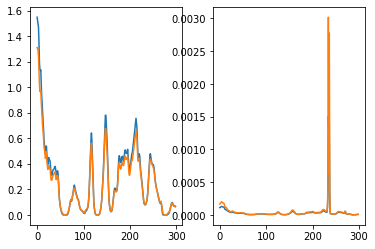

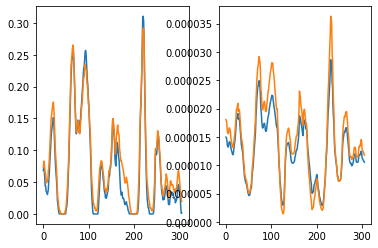

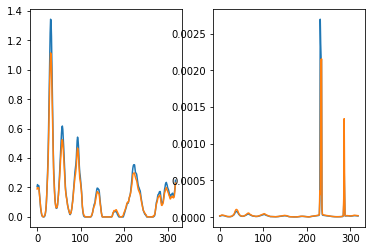

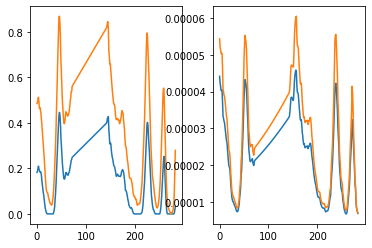

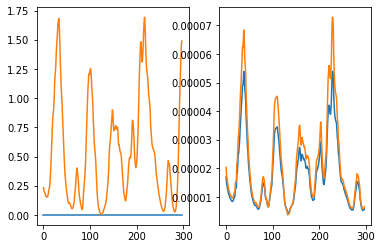

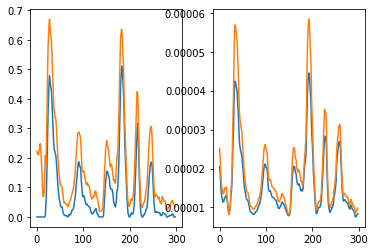

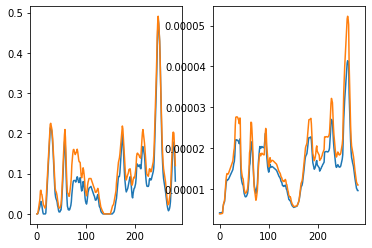

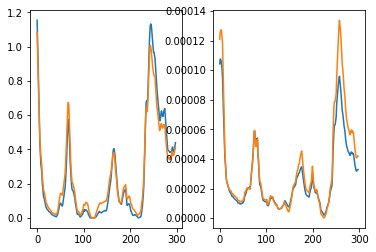

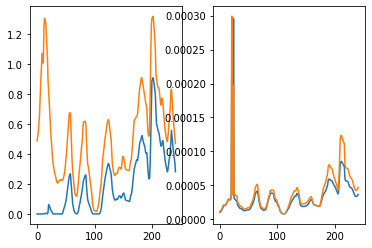

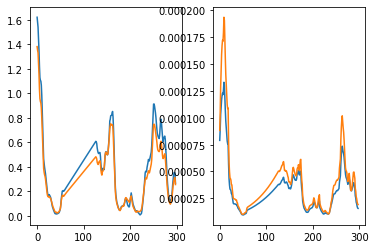

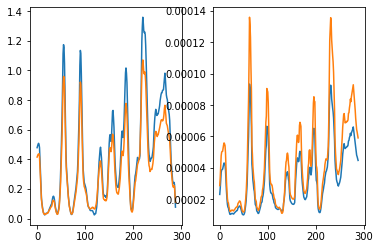

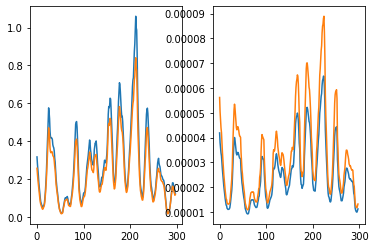

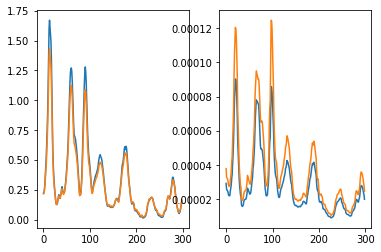

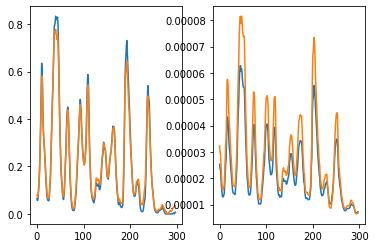

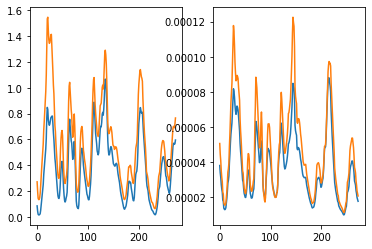

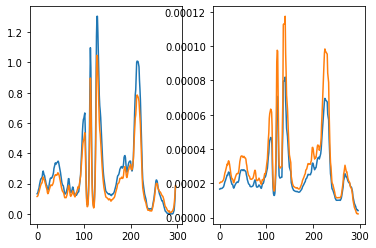

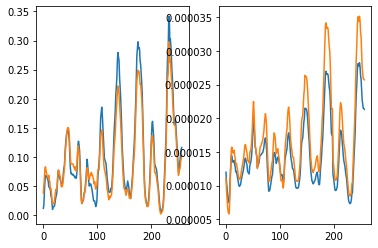

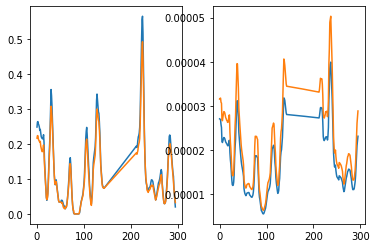

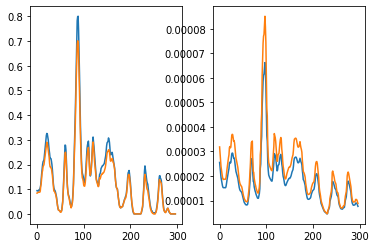

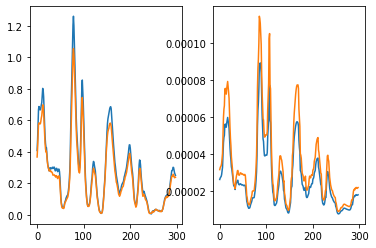

In [21]:
MAX = 0
MIN = 1000000

for data in dataset:
    
    fig, axs = plt.subplots(1,2)

    axs[0].plot(data.meas_vind_1.to_numpy())
    axs[0].plot(data.meas_vind_2.to_numpy())
    axs[1].plot(data.synth_vind_1.to_numpy())
    axs[1].plot(data.synth_vind_2.to_numpy())
    plt.show()
#     MAX = max(MAX, np.max(c1[:,2]))
#     MIN = min(MIN, np.min(c1[:,2]))

# print(MIN, MAX)

In [98]:
# 

In [17]:
# dataset = load_dataset('synth_01')
# for n, data in enumerate(dataset):
#     file_path = 'C:/Users/mixil/Desktop/MIHAR_Hardware/experiments/dataset/synth_01/data_/record_' + "{0:0=4d}".format(n) + '.csv'
#     data = data.loc[:, ['time','norm','center_1','center_2','synth_vind_1', 'synth_vind_2']]
#     data.to_csv(file_path, index=None) 